# Reconstruction of systems of 1st order linear DEs by multiple time series

The method of choice is the analysis given in [1,2] for time series' in a high dimensional space. First we explain the 1D approach by means of a Principle Component Analysis.

The basic principle is best explained in a 1D system. Given a time series $x(t)$ we are looking for a DE $\dot y(t)=f(y)$ which by integration reproduces the time series $x(t)$. To this end we minimize the mean square deviation
$$ W=\langle (\dot x(t)-f(x(t))^2\rangle $$
where
$$ \langle W(t)\rangle = \frac{1}{t_1-t_0}\int\limits_{t_0}^{t_1} W(t)dt $$
For $f(x(t))$ we make an ansatz $f(x(t))=\sum_i a_i\phi_i(x(t))$. Minimizing $W(t)$ gives the $a_i$ by $\frac{\partial W}{\partial a_i}=0$ to yield
$$ a_i=\langle \dot x\phi_j(x)\rangle D^{-1}_{ji}\mbox{ where } D_{ij}=\langle \phi_i(x)\phi_j(x)\rangle $$

For high dimensional Systems we introduce the coupling of the time series'. Given a high dimensional signal $\mathbf{x}(t)$ we want to find the corresponding equation of motion. In this case we have for the component $i$ of the vector $\mathbf{f}$
$$ f_i(\mathbf{x}) = a^{ij}x_j+a^{ijk}x_jx_k\dots$$


[1]  K. Karhunen, "Zur Spektraltheorie stochastischer Prozesse," Ann. Acad. Sci. Fenn. A1, Math. Phys. 37 (1946)

[2] C. Uhl, Analyse raumzeitlicher Daten strukturbildender Systeme, Verlag Shaker (1995)

Still to be found: M. Loeve, “Fonctions aleatoires de second ordre,” Comptes Rendus De L'Académie Des Sciences, vol. 220, (1945).

### Load the respective libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
import numpy.polynomial.polynomial as poly

### Get the data

In [2]:
numbered=np.load('Numbered.npy',allow_pickle=True).item()

In [3]:
#
npzfile=np.load('CDR_Data.npz')
yC=npzfile['yC']
yD=npzfile['yD']
yR=npzfile['yR']
#
# The following should be the same for all three and is for plotting
countries=yC.shape[0]
x=np.arange(yC.shape[1])

#### In case we want to check what we read we define plotting functions for the data retrieved, linear plot and log plot

# 1D System

We define $\phi_i(x)$ and calculate $D_{ij}=\langle \phi_i(x)\phi_j(x)\rangle$ as well as its inverse $D_{ij}^{-1}$

In [4]:
def DVecCMat(ydot,XV,n):
    x,v=XV
    laver=len(x)
    l=(n+1)*(n+2)//2
    cijn=np.append(np.array(np.where(np.less_equal(*np.mgrid[-n-1:0,-1:-n-2:-1]))),np.arange(l)).reshape(3,l).T
    dim=len(cijn)
    c=np.zeros((dim,dim),dtype=float)
    d=np.zeros(dim,dtype=float)
    for i,j,r in cijn:
        d[r]=np.sum(ydot*x**i*v**j)
        for k,l,s in cijn:
            c[r,s]=np.sum(x**i*v**j*x**k*v**l)
    return d,c
#
def ffit(t,r,*argv):
    x,v=r
    #return np.asarray(argv[0])
    #axdot,avdot=np.asarray(argv[0])
    axdot,avdot=argv
    l=len(axdot)
    n=int((-3+np.sqrt(1+8*l))//2)
    c=np.zeros((n+1,n+1),dtype=float)
    cbool=np.less_equal(*np.mgrid[-n-1:0,-1:-n-2:-1])
    c[cbool]=axdot
    dxdt=poly.polyval2d(x,v,c)
    l=len(avdot)
    n=int((-3+np.sqrt(1+8*l))//2)
    c=np.zeros((n+1,n+1),dtype=float)
    cbool=np.less_equal(*np.mgrid[-n-1:0,-1:-n-2:-1])
    c[cbool]=avdot
    dvdt=poly.polyval2d(x,v,c)
    return dxdt,dvdt
# Define r.h.s. of DE
#def f(t,y):
#    return np.sum([ai[i]*phi(i,y) for i in np.arange(4)],axis=0)

In [5]:
# Let's start with the coupling of EU and US
# Identify all EU Countries
EUCountries=('Belgium','Bulgaria','Denmark','Germany','Estonia','Finland','France','Greece','Ireland','Italy','Croatia',
            'Latvia','Lithuania','Luxembourg','Malta','Netherlands','Austria','Poland','Portugal','Romania','Slovenia',
             'Sweden','Slovakia','Spain','Czechia','Hungary','Cyprus','United Kingdom')
# Sum up the EU countries ...
yEU=np.zeros(len(yC[numbered.get('Germany')]))   
yDEU=np.zeros(len(yC[numbered.get('Germany')]))   
for country in EUCountries: 
    yEU+=yC[numbered.get(country)]
    yDEU+=yD[numbered.get(country)]
# ... and get the US figures
yUS=yC[numbered.get('US')]
#
t0=0.
t1=float(len(yC[numbered.get('Germany')]))
dt=1.0
teval=np.arange(len(yEU))
XV=[yEU,yUS]
# Do the time derivative of the data
yEUdot=np.gradient(yEU,dt,edge_order=2)
yUSdot=np.gradient(yUS,dt,edge_order=2)
# Fit the time derivative of the two time series' to a 
norder=5
# Calculate the coefficients for the r.h.s. of vdot
d,c=DVecCMat(yEUdot,XV,norder)
#print(np.einsum('ij,j->i',np.linalg.inv(c),d)[[1,4,7]],'\n',axdot[[1,4,7]])
axdot=np.einsum('ij,j->i',np.linalg.inv(c),d)
# Calculate the coefficients for the r.h.s. of vdot
d,c=DVecCMat(yUSdot,XV,norder)
#print(np.einsum('ij,j->i',np.linalg.inv(c),d)[[1,4,7]],'\n',avdot[[1,4,7]])
avdot=np.einsum('ij,j->i',np.linalg.inv(c),d)

In [6]:
rtol=1.e-12
atol=1.e-14
r0=[yEU[0],yUS[0]]
solfit=solve_ivp(ffit, [t0, t1], r0,method='DOP853',t_eval=teval,rtol=rtol,atol=atol,args=(axdot,avdot))

<IPython.core.display.Javascript object>


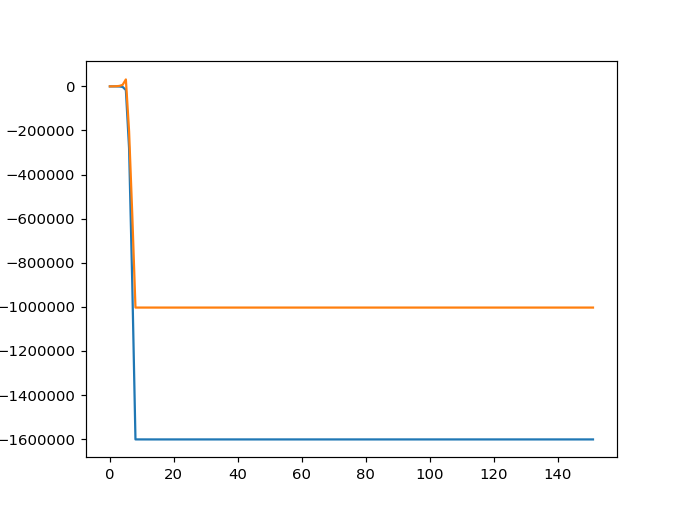

In [7]:
%matplotlib notebook
plt.plot(solfit.y[0])
plt.plot(solfit.y[1])

In [ ]:
n=3
c=np.zeros((n+1,n+1),dtype=float)
cbool=np.less_equal(*np.mgrid[-n-1:0,-1:-n-2:-1])

In [ ]:
cbool.shape

In [ ]:
len(axdot)

In [ ]:
norder=4
# Calculate the coefficients for the r.h.s. of vdot
d,c=DVecCMat(yEUdot,XV,norder)
#print(np.einsum('ij,j->i',np.linalg.inv(c),d)[[1,4,7]],'\n',axdot[[1,4,7]])
axdot=np.einsum('ij,j->i',np.linalg.inv(c),d)